In [1]:
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot
import cam
import ECGplot

import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd
from tqdm import tqdm

import time
import math
import os
import gc
from torch.utils.tensorboard import SummaryWriter

import sys
import logger

def seed_torch(seed=2023):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False 
	torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.enabled = False

In [2]:
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
DEVICE = "cpu"
seed_torch(2023)

cuda:0


In [3]:
ALLDataset = ECGDataset.ECG_Dataset_Init('/workspace/data/Preprocess_HTN/data_like_pxl//',filter_age= 18,filter_department='外科',rebuild_flage=False)    
ALLDataset.report()  # type: ignore
torch.cuda.empty_cache()# 清空显卡cuda
test_dataset = ECGDataset.ECG_Dataset('/workspace/data/Preprocess_HTN/data_like_pxl//',ALLDataset.testDf)  # type: ignore  
all_dataset = ALLDataset.INFOsDf.copy()
all_dataset = all_dataset.sample(frac=1).reset_index(drop=True) 
# test_dataset = ECGDataset.ECG_Dataset('/workspace/data/Preprocess_HTN/data_like_pxl//',ALLDataset.testDf)  # type: ignore  
test_size = len(all_dataset[(all_dataset['diagnose']==1)])//5
test_pair_Df = pair_HTN(all_dataset[(all_dataset['diagnose']==1)].iloc[:test_size],all_dataset[(all_dataset['diagnose']==0)],Range_max = 15,shuffle=True)
test_dataset = ECGDataset.ECG_Dataset('/workspace/data/Preprocess_HTN/data_like_pxl//',test_pair_Df)

105375
              HTN        NHTN   
   nums       1871      103504  


            orginal            QC         
   nums      105375          66163        
reset size 15
delete size 99
              HTN        NHTN   
   nums       1289      64775   


            orginal   filtered department 
   nums      66064           13896        
              HTN        NHTN   
   nums       1289      12607   


            orginal     removed ages NaN  
   nums      13896           13896        
              HTN        NHTN   
   nums       1289      12607   


            orginal      filtered ages    
   nums      13896           13520        
              HTN        NHTN   
   nums       1273      12247   


            orginal   removed diagnose NaN
   nums      13520           13517        
              HTN        NHTN   
   nums       1282      12235   


ERR labels num: 17


            orginal    removed duplicated 
   nums      13517           11410        
              HTN  

In [4]:
NET = [Net.MLBFNet(num_class = 2,mark = True,res = True,se = True,Dropout_rate = 0.3) ] # type: ignore
testmodel = NET[0].to(DEVICE)

In [5]:
Models_path = "/workspace/data/Interpretable_HTN/model/20230125_083423/20230125_083423/BestF1_2.pt"

In [6]:
testmodel.load_state_dict(torch.load(Models_path))
test_dataloader = Data.DataLoader(dataset=test_dataset, shuffle= False,batch_size=128)
test_acc = []   
criterion = torch.nn.CrossEntropyLoss() 
y_true,y_pred,test_loss,test_acc = eval_model(test_dataloader,criterion,testmodel,DEVICE) # 测试模型
print('loss =',test_loss,'acc =',test_acc)
print('f1_macro =',f1_score(y_true, y_pred, average='macro')) 
print('f1_micro =',f1_score(y_true, y_pred, average='micro')) 
print('f1_binary =',f1_score(y_true, y_pred, average='binary')) 
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
print("Confusion Matrix: ")
print(cm)

loss = 0.3709450997412205 acc = 0.845703125
f1_macro = 0.8370527595501811
f1_micro = 0.8370535714285714
f1_binary = 0.8366890380313199
Confusion Matrix: 
[[188  36]
 [ 37 187]]


GET CAM Value

In [7]:
testmodel.eval()
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

# 获取反向的传播图
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)

In [8]:
testmodel.load_state_dict(torch.load(Models_path))

<All keys matched successfully>

In [9]:
testmodel.layers0.register_forward_hook(farward_hook)	#正向传播
testmodel.layers1.register_forward_hook(farward_hook) 
testmodel.layers2.register_forward_hook(farward_hook)	#正向传播
testmodel.layers3.register_forward_hook(farward_hook) 
testmodel.layers4.register_forward_hook(farward_hook)	#正向传播
testmodel.layers5.register_forward_hook(farward_hook) 
testmodel.layers6.register_forward_hook(farward_hook)	#正向传播
testmodel.layers7.register_forward_hook(farward_hook) 
testmodel.layers8.register_forward_hook(farward_hook)	#正向传播
testmodel.layers9.register_forward_hook(farward_hook) 
testmodel.layers10.register_forward_hook(farward_hook)	#正向传播
testmodel.layers11.register_forward_hook(farward_hook) 
testmodel.conv3.register_forward_hook(farward_hook) 
testmodel.layers_list_2d[0].register_forward_hook(farward_hook) 
testmodel.layers_list_2d[1].register_forward_hook(farward_hook) 
testmodel.layers_list_2d[2].register_forward_hook(farward_hook)  

In [10]:
testmodel.layers0.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers1.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers2.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers3.register_full_backward_hook(backward_hook)#反向传播 
testmodel.layers4.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers5.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers6.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers7.register_full_backward_hook(backward_hook)#反向传播 
testmodel.layers8.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers9.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers10.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers11.register_full_backward_hook(backward_hook)#反向传播
testmodel.conv3.register_full_backward_hook(backward_hook)#反向传播
testmodel.layers_list_2d[0].register_full_backward_hook(backward_hook)#反向传播
testmodel.layers_list_2d[1].register_full_backward_hook(backward_hook)#反向传播
testmodel.layers_list_2d[2].register_full_backward_hook(backward_hook)#反向传播

In [11]:
branch_fmap_sum_HTN = np.zeros(27)
branch_fmap_sum_NHTN = np.zeros(27)

for itme in (range(448)):
    layer2d_vlue_list = list()
    # testmodel.layer4.register_forward_hook(farward_hook)	#正向传播
    # testmodel.layer4.register_full_backward_hook(backward_hook)#反向传播
    fmap_block = list()
    grad_block = list()
    inputs,labels = test_dataset.__getitem__(itme)
    labels = torch.tensor(labels)
    labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
    inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)  
    testmodel.eval()
    outputs = testmodel(inputs)
    _,pred = outputs.max(1)     # 求概率最大值对应的标签
    loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
    loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用
    for i in range(12):
        layer2d_vlue = cam.caculate_layer_cam_vlue(fmap_block[i][0].clone().detach().cpu().numpy(),grad_block[15-i][0].clone().detach().cpu().numpy()) #input(C,W) output(original_seq_lenth,)
        layer2d_vlue_list.append(layer2d_vlue)
    for i in range(12,16):
        layer2d_vlue = cam.caculate_layer_cam_vlue_2d(fmap_block[i][0].clone().detach().cpu().numpy(),grad_block[15-i][0].clone().detach().cpu().numpy()) #input(C,H,W) output(lead,original_seq_lenth)
        layer2d_vlue_list.append(layer2d_vlue)
    if(((labels.tolist())[0]) == torch.tensor(1)):
        for i in range(12):
            branch_fmap_sum_HTN[i] += layer2d_vlue_list[i].sum()
        for i in range(12,24):
            branch_fmap_sum_HTN[i] += layer2d_vlue_list[12][i-12,:].sum()
    else:
        for i in range(12):
            branch_fmap_sum_NHTN[i] += layer2d_vlue_list[i].sum()
        for i in range(12,24):
            branch_fmap_sum_NHTN[i] += layer2d_vlue_list[12][i-12,:].sum()
    # # print("labels: {}".format(labels))
    # # print("predict: {}".format(pred))
    # # loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
    # # # loss = (testmodel.last_out)[0,pred]
    # # loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用
    # if(((labels.tolist())[0]) == torch.tensor(1)):
    #     for i in range(12):
    #         branch_fmap_sum_HTN[i]= branch_fmap_sum_HTN[i] + fmap_block[i].to('cpu').sum().detach().numpy()
    #         # print(fmap_block[i].size())
    #     for i in range(12,24):
    #         branch_fmap_sum_HTN[i]= branch_fmap_sum_HTN[i] + fmap_block[12][0,:,i-12].to('cpu').sum().detach().numpy()
    #     branch_fmap_sum_HTN[24] = fmap_block[13].to('cpu').sum().detach().numpy()
    #     branch_fmap_sum_HTN[25] = fmap_block[14].to('cpu').sum().detach().numpy()
    #     branch_fmap_sum_HTN[26] = fmap_block[15].to('cpu').sum().detach().numpy()
    # else:
    #     for i in range(12):
    #         branch_fmap_sum_NHTN[i]= branch_fmap_sum_NHTN[i] + fmap_block[i].to('cpu').sum().detach().numpy()
    #         # print(fmap_block[i].size())
    #     for i in range(12,24):
    #         branch_fmap_sum_NHTN[i]= branch_fmap_sum_NHTN[i] + fmap_block[12][0,:,i-12].to('cpu').sum().detach().numpy()
    #     branch_fmap_sum_NHTN[24] = fmap_block[13].to('cpu').sum().detach().numpy()
    #     branch_fmap_sum_NHTN[25] = fmap_block[14].to('cpu').sum().detach().numpy()
    #     branch_fmap_sum_NHTN[26] = fmap_block[15].to('cpu').sum().detach().numpy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


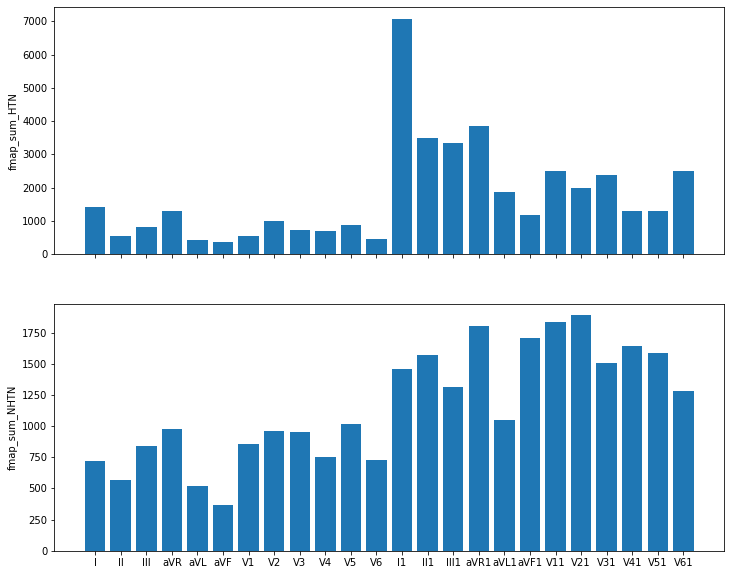

In [12]:
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(nrows = 2,ncols = 1,figsize=(12,10) ,sharex=True)  # type: ignore

leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6','I1', 'II1', 'III1', 'aVR1', 'aVL1', 'aVF1', 'V11', 'V21', 'V31', 'V41', 'V51', 'V61',]
counts = branch_fmap_sum_HTN[:24].tolist()
ax0.bar(leads, counts)
ax0.set_ylabel('fmap_sum_HTN')

counts = branch_fmap_sum_NHTN[:24].tolist()
ax1.bar(leads, counts)
ax1.set_ylabel('fmap_sum_NHTN')
plt.show()

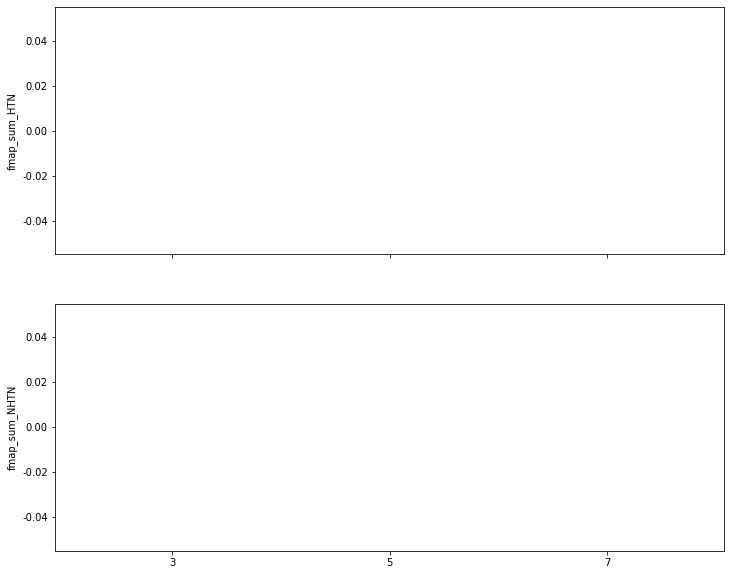

In [13]:
fig, (ax0, ax1) = plt.subplots(nrows = 2,ncols = 1,figsize=(12,10) ,sharex=True)  # type: ignore

leads = ['3', '5', '7']
counts = branch_fmap_sum_HTN[24:].tolist()
ax0.bar(leads, counts)
ax0.set_ylabel('fmap_sum_HTN')

counts = branch_fmap_sum_NHTN[24:].tolist()
ax1.bar(leads, counts)
ax1.set_ylabel('fmap_sum_NHTN')
plt.show()

layer cam

In [ ]:
NET = [Net.MLBFNet(num_class= 2,mark=True,res = True,se = True,Dropout_rate = 0.25) ] # type: ignore
testmodel = NET[0].to(DEVICE)
testmodel.load_state_dict(torch.load(Models_path+"/parameter_EarlyStoping_"+str(0)+".pt"))

In [ ]:
testmodel.eval()
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

# 获取反向的传播图
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)

In [ ]:
testmodel.conv3.register_forward_hook(farward_hook)	#正向传播
testmodel.conv3.register_full_backward_hook(backward_hook)#反向传播

In [ ]:
def plot_top_attention_points(fig,axs,x,y,color_depend,cmap = "jet",y_name = "Voltage(mV)",title="",top_num = 100):
    axs.plot(x,y, color='black',linewidth=0.5)
    
    top_idx=color_depend.argsort()[::-1][0:top_num]
    axs.scatter(top_idx, y[top_idx],s=2,c='r')
    #fig.colorbar(line, ax=axs)
    axs.set_xlim(x.min(), x.max())
    axs.set_ylim(-3500, +3500)

    axs.set_aspect(0.2)#用于设置轴缩放的方面，即y-unit与x-unit的比率
    axs.xaxis.set_major_locator(plt.MultipleLocator(100))# type: ignore # 100*0.002s=0.2s = 5格
    axs.xaxis.set_minor_locator(plt.MultipleLocator(20)) # type: ignore # 20*0.002=0.004S = 1格
    axs.yaxis.set_major_locator(plt.MultipleLocator(500))# type: ignore # 0.1uv*500 = 0.5ms = 5格
    axs.yaxis.set_minor_locator(plt.MultipleLocator(100))# type: ignore # 0.1uv*100 =0.1ms = 1格 

    #axs.xaxis.set_major_formatter(plt.NullFormatter()) #x轴不显示刻度值/lable per 0.2s
    axs.xaxis.set_major_formatter(lambda x, pos: str(round(0.2*(x/100.0),2))) #x轴 lable per 0.2s
    axs.yaxis.set_major_formatter(lambda x, pos: str(x/1000.0)) # label per '0.5 mv'，turn uV to mv

    axs.grid(which='major', axis='x', linewidth=0.3, linestyle='-', color='b')
    axs.grid(which='minor', axis='x', linewidth=0.1, linestyle='-', color='b')
    axs.grid(which='major', axis='y', linewidth=0.3, linestyle='-', color='b')
    axs.grid(which='minor', axis='y', linewidth=0.1, linestyle='-', color='b')
    axs.set_ylabel(y_name)
    axs.set_title(title)
    axs.grid(True, which='both')

In [ ]:
for itme in tqdm(range(10)):
    fmap_block = list()
    grad_block = list()
    inputs,labels = test_dataset.__getitem__(itme)

    labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
    inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)  

    outputs = testmodel(inputs)
    _,pred = outputs.max(1)     # 求概率最大值对应的标签
    # print("labels: {}".format(labels))
    # print("predict: {}".format(pred))
    loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
    # loss = (testmodel.last_out)[0,pred]
    loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用
    fmap = (fmap_block[0][0]).to('cpu').detach().numpy()
    gradmap = (grad_block[0][0]).to('cpu').detach().numpy()
    layer2d_vlue = cam.caculate_layer_cam_vlue_2d(fmap,gradmap)
    lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    x_index = np.arange(0,EcgLength_num)
    fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True,sharey=True,figsize=(50,60), constrained_layout=True)
    ecg_data = (inputs[0]).to('cpu')
    for i,ax in enumerate(axs.flat):  # type: ignore
        attention_value_each_timestep = layer2d_vlue[i]
        #plot_y = x[1,i,:]*(4.88)
        plot_y = np.array(ecg_data[i]*3500.)
        ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])
        plot_top_attention_points(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i],top_num=500)
    plt.savefig(Models_path+'/layer_cam//'+str(itme)+'_'+str(labels[0].tolist())+'_'+str(pred[0].tolist())+'_''.jpg', bbox_inches='tight',dpi = 100)

# single sampel

In [ ]:
def amplitude_limiting(ecg_data,max_bas = 3500):
    ecg_data = ecg_data*4.88
    ecg_data[ecg_data > max_bas] = max_bas
    ecg_data[ecg_data < (-1*max_bas)] = -1*max_bas
    return ecg_data/max_bas

In [ ]:
NET = [Net.MLBFNet(num_class=2,mark=True,res = True,se = True,Dropout_rate = 0.25) ] # type: ignore
testmodel = NET[0].to(DEVICE)
Models_path = "./model/20221206_095840/"
testmodel.load_state_dict(torch.load(Models_path+"/parameter_EarlyStoping_"+str(0)+".pt"))

In [ ]:
testmodel.conv3.register_forward_hook(farward_hook)	#正向传播
testmodel.conv3.register_full_backward_hook(backward_hook)#反向传播

In [ ]:
# 定义获取梯度的函数
fmap_block = list()
grad_block = list()

# 获取反向的传播图
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 定义获取特征图的函数
def farward_hook(module, input, output):
    fmap_block.append(output)

In [ ]:
patients_list = ['21-1-1489_35-0_HTN',
'21-1-2739_94-0_HTN',
'21-1-2895_40-1_HTN',
'21-1-306_59-0_HTN',
'21-1-3118_35-1_HTN',
'21-1-3131_48-1_HTN',
'21-1-3932_47-1_HTN',
'21-1-4325_51-0_HTN',
'21-1-99_48-1_HTN',
'21-10-190_53-0_HTN',
'21-10-3164_71-0_HTN',
'21-10-3349_78-1_HTN',
'21-10-3350_78-1_HTN',
'21-10-752_50-1_HTN',
'21-11-3157_47-1_HTN',
'21-12-2247_74-0_HTN',
'21-12-2956_41-0_HTN',
'21-12-4151_38-0_HTN',
'21-12-624_77-1_HTN',
'21-3-1003_61-1_HTN',
'21-3-1580_53-0_HTN',
'21-3-3226_50-1_HTN',
'21-3-727_72-0_HTN',
'21-3-821_30-1_HTN',
'21-4-1029_38-1_HTN',
'21-4-1388_69-0_HTN',
'21-4-2463_49-0_HTN',
'21-4-2951_48-0_HTN',
'21-4-3683_6-1_HTN',
'21-4-3684_6-1_HTN',
'21-5-152_58-1_HTN',
'21-5-3171_41-1_HTN',
'21-5-6_65-0_HTN',
'21-6-4126_29-1_HTN',
'21-7-3375_70-1_HTN',]


In [ ]:
for patient in patients_list:
    inputs = np.load('/workspace/data/Preprocess_HTN/data_like_pxl/ECG/'+patient+'.npy')
    labels = torch.from_numpy(np.array(1)).long()
    infos =pd.read_pickle('/workspace/data/Preprocess_HTN/data_like_pxl/INFO/'+patient+'.pkl')
    print(inputs,infos)
    inputs = amplitude_limiting(inputs)
    inputs = torch.FloatTensor(inputs)
    testmodel.eval()
    fmap_block = list()
    grad_block = list()


    labels = labels.unsqueeze(0) # 在首位添加1维作为batchsize
    inputs = inputs.unsqueeze(0) # 在首位添加1维作为batchsize

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)  

    outputs = testmodel(inputs)
    print('outputs',outputs)
    _,pred = outputs.max(1)     # 求概率最大值对应的标签
    # print("labels: {}".format(labels))
    # print("predict: {}".format(pred))
    loss = outputs[0,pred]      # 网络对应于pred的类别的输出即为loss
    # loss = (testmodel.last_out)[0,pred]
    loss.backward(retain_graph=True)  #retain_graph=True，目的为是为保留该过程中计算的梯度，后续G网络更新时使用
    fmap = (fmap_block[0][0]).to('cpu').detach().numpy()
    gradmap = (grad_block[0][0]).to('cpu').detach().numpy()
    layer2d_vlue = cam.caculate_layer_cam_vlue_2d(fmap,gradmap)
    lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    x_index = np.arange(0,EcgLength_num)
    fig, axs = plt.subplots(nrows=6, ncols=2, sharex=True,sharey=True,figsize=(50,60), constrained_layout=True)
    ecg_data = (inputs[0]).to('cpu')
    for i,ax in enumerate(axs.flat):  # type: ignore
        attention_value_each_timestep = layer2d_vlue[i]
        #plot_y = x[1,i,:]*(4.88)
        plot_y = np.array(ecg_data[i]*3500.)
        ECGplot.plot_multicolored_line(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i])
        plot_top_attention_points(fig,ax,x = x_index,y= plot_y,color_depend=attention_value_each_timestep,cmap="jet",y_name = str(lead_index[i])+" Voltage(mV)",title = lead_index[i],top_num=500)
    plt.savefig(Models_path+'/'+patient+'_'+str(labels[0].tolist())+'_'+str(pred[0].tolist())+'_''.jpg', bbox_inches='tight',dpi = 100)
    